In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/openfda-data500/drugs_data.xlsx
/kaggle/input/openfda-data500/drugs_data (1).csv
/kaggle/input/openfda-data500/drugs_data.json
/kaggle/input/openfda-data500/drug_qa_dataset.csv


In [ ]:
# Install required packages
!pip install bert-score
!pip install rouge-score
!pip install evaluate
!pip install nltk
!pip install peft

In [7]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5ForConditionalGeneration, T5Tokenizer,
    GPT2LMHeadModel, GPT2Tokenizer,
    AutoModelForSeq2SeqLM, AutoTokenizer,
    TrainingArguments, Trainer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments
)
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
import json
import re
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import additional metrics libraries
from bert_score import BERTScorer
from rouge_score import rouge_scorer
import evaluate
from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [8]:
# Load and preprocess the data
df = pd.read_csv('/kaggle/input/openfda-data500/drugs_data (1).csv')

print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Data preprocessing
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = str(text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,!?;:()\-\']', '', text) # Kept apostrophe for contractions
    return text.strip()

# Preprocess all text columns
text_columns = ['dosage', 'active_ingredients', 'drug_interactions', 'side_effects',
                'indications', 'contraindications', 'warnings', 'precautions']

for col in text_columns:
    df[col] = df[col].apply(preprocess_text)

# Create context from all columns for each drug
def create_drug_context(row):
    context_parts = []
    context_parts.append(f"Drug Name: {row['drug_name']}")

    if row['dosage']:
        context_parts.append(f"Dosage: {row['dosage']}")
    if row['active_ingredients']:
        context_parts.append(f"Active Ingredients: {row['active_ingredients']}")
    if row['drug_interactions'] and row['drug_interactions'] != 'Not specified':
        context_parts.append(f"Drug Interactions: {row['drug_interactions']}")
    if row['side_effects']:
        context_parts.append(f"Side Effects: {row['side_effects']}")
    if row['indications']:
        context_parts.append(f"Indications: {row['indications']}")
    if row['contraindications'] and row['contraindications'] != 'Not specified':
        context_parts.append(f"Contraindications: {row['contraindications']}")
    if row['warnings']:
        context_parts.append(f"Warnings: {row['warnings']}")
    if row['precautions'] and row['precautions'] != 'Not specified':
        context_parts.append(f"Precautions: {row['precautions']}")

    return " | ".join(context_parts)

df['context'] = df.apply(create_drug_context, axis=1)

print(f"\nSample context for {df.iloc[0]['drug_name']}:")
print(df.iloc[0]['context'][:500] + "...")

# Create expanded QA pairs with more diverse questions
def generate_qa_pairs(row):
    qa_pairs = []
    drug_name = row['drug_name']
    context = row['context']

    # Expanded questions covering all aspects
    questions_answers = [
        # Basic information
        (f"What is {drug_name} used for?", row['indications'] or "Information not specified"),
        (f"What is the dosage for {drug_name}?", row['dosage'] or "Dosage information not specified"),
        (f"What are the side effects of {drug_name}?", row['side_effects'] or "Side effects information not specified"),
        (f"What are the warnings for {drug_name}?", row['warnings'] or "Warning information not specified"),
        (f"What are the active ingredients in {drug_name}?", row['active_ingredients'] or "Active ingredients not specified"),
        
        # Additional medical questions
        (f"What are the contraindications for {drug_name}?", row['contraindications'] or "Contraindications not specified"),
        (f"What precautions should be taken with {drug_name}?", row['precautions'] or "Precautions not specified"),
        (f"Does {drug_name} interact with other medications?", row['drug_interactions'] or "Drug interaction information not specified"),
        
        # Safety and usage questions
        (f"Who should not take {drug_name}?", row['contraindications'] or "Contraindications not specified"),
        (f"How should I safely use {drug_name}?", row['precautions'] or "Precautions not specified"),
        (f"What should I avoid while taking {drug_name}?", row['precautions'] or "Precautions not specified"),
        
        # Mechanism and composition
        (f"What is in {drug_name}?", row['active_ingredients'] or "Active ingredients not specified"),
        (f"How does {drug_name} work?", row['indications'] or "Mechanism information not specified"),
        
        # Risk-related questions
        (f"What are the risks of taking {drug_name}?", row['warnings'] or "Risk information not specified"),
        (f"What serious side effects can {drug_name} cause?", row['side_effects'] or "Serious side effects information not specified"),
        
        # Administration questions
        (f"How do I take {drug_name}?", row['dosage'] or "Administration information not specified"),
        (f"When should I not use {drug_name}?", row['contraindications'] or "Contraindications not specified"),
        
        # Combination and interaction questions
        (f"Can {drug_name} be taken with other drugs?", row['drug_interactions'] or "Drug interaction information not specified"),
        (f"What medications interact with {drug_name}?", row['drug_interactions'] or "Drug interaction information not specified"),
        
        # Comprehensive questions
        (f"Tell me everything about {drug_name}.", context),
        (f"Provide complete information about {drug_name}.", context),
    ]

    for question, answer in questions_answers:
        qa_pairs.append({
            'input_text': f"question: {question} context: {context}",
            'target_text': answer
        })

    return qa_pairs

# Generate all QA pairs
all_qa_pairs = []
for _, row in df.iterrows():
    all_qa_pairs.extend(generate_qa_pairs(row))

qa_df = pd.DataFrame(all_qa_pairs)
print(f"\nGenerated {len(qa_df)} QA pairs")
print(f"Average questions per drug: {len(qa_df) / len(df):.1f}")

Dataset shape: (500, 9)
Columns: ['drug_name', 'dosage', 'active_ingredients', 'drug_interactions', 'side_effects', 'indications', 'contraindications', 'warnings', 'precautions']

Sample context for aspirin:
Drug Name: aspirin | Dosage: Directions drink a full glass of water with each dose adults and children 12 years and over: take 4 to 8 tablets every 4 hours not to exceed 48 tablets in 24 hours unless directed by a doctor children under 12 years: consult a doctor | Active Ingredients: ASPIRIN | Side Effects: Warnings Reye's syndrome : Children and teenagers who have or are recovering from chicken pox or flu-like symptoms should not use this product. When using this product, if changes in behavior...

Generated 10500 QA pairs
Average questions per drug: 21.0


In [9]:
# Split the data
train_df, temp_df = train_test_split(qa_df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"Training samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)}")
print(f"Test samples: {len(test_df)}")

# Initialize models
print("\nLoading T5 model...")
t5_model_name = "t5-small"
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_name)
t5_model = T5ForConditionalGeneration.from_pretrained(t5_model_name)

print("Loading GPT-2 model...")
gpt2_model_name = "gpt2"
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_name)

print("Loading FLAN-T5 model...")
flan_t5_model_name = "google/flan-t5-small"
flan_t5_tokenizer = AutoTokenizer.from_pretrained(flan_t5_model_name)
flan_t5_model = AutoModelForSeq2SeqLM.from_pretrained(flan_t5_model_name)

Training samples: 7350
Validation samples: 1575
Test samples: 1575

Loading T5 model...


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Loading GPT-2 model...


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Loading FLAN-T5 model...


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [10]:
# Configure LoRA for GPT-2
lora_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["c_attn", "c_proj", "c_fc"]
)

gpt2_model = get_peft_model(gpt2_model, lora_config)
print("GPT-2 trainable parameters:")
gpt2_model.print_trainable_parameters()

GPT-2 trainable parameters:
trainable params: 1,179,648 || all params: 125,619,456 || trainable%: 0.9391


In [11]:
# Create datasets
class DrugQADataset(Dataset):
    def __init__(self, dataframe, tokenizer, model_type, max_length=384):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.model_type = model_type
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data.iloc[idx]
        input_text = item['input_text']
        target_text = item['target_text']

        if self.model_type == "t5":
            # T5 and FLAN-T5 encoding
            inputs = self.tokenizer(
                input_text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            )

            targets = self.tokenizer(
                target_text,
                max_length=256,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            )

            return {
                'input_ids': inputs['input_ids'].squeeze(),
                'attention_mask': inputs['attention_mask'].squeeze(),
                'labels': targets['input_ids'].squeeze()
            }
        else:
            # GPT-2 encoding
            text = f"{input_text} Answer: {target_text}{self.tokenizer.eos_token}"
            encoding = self.tokenizer(
                text,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            )

            return {
                'input_ids': encoding['input_ids'].squeeze(),
                'attention_mask': encoding['attention_mask'].squeeze(),
                'labels': encoding['input_ids'].squeeze()
            }

# Create datasets for all models
t5_train_dataset = DrugQADataset(train_df, t5_tokenizer, "t5")
t5_val_dataset = DrugQADataset(val_df, t5_tokenizer, "t5")
t5_test_dataset = DrugQADataset(test_df, t5_tokenizer, "t5")

gpt2_train_dataset = DrugQADataset(train_df, gpt2_tokenizer, "gpt2")
gpt2_val_dataset = DrugQADataset(val_df, gpt2_tokenizer, "gpt2")
gpt2_test_dataset = DrugQADataset(test_df, gpt2_tokenizer, "gpt2")

flan_t5_train_dataset = DrugQADataset(train_df, flan_t5_tokenizer, "t5")
flan_t5_val_dataset = DrugQADataset(val_df, flan_t5_tokenizer, "t5")
flan_t5_test_dataset = DrugQADataset(test_df, flan_t5_tokenizer, "t5")

In [12]:
# Manual training function
def train_model_manual(model, train_dataset, val_dataset, tokenizer, model_name, num_epochs=3):
    """Manual training loop"""
    print(f"Starting manual training for {model_name}...")

    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

    model.to(device)
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")

        for batch in progress_bar:
            # Move batch to device
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Forward pass
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss

            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")

    # Save model
    model.save_pretrained(f'./{model_name}-manual')
    tokenizer.save_pretrained(f'./{model_name}-manual')
    print(f"{model_name} manual training completed!")

    return model

# Train models (reduced epochs for demonstration)
print("\nStarting training for all models...")
t5_model = train_model_manual(t5_model, t5_train_dataset, t5_val_dataset, t5_tokenizer, "t5", num_epochs=3)
gpt2_model = train_model_manual(gpt2_model, gpt2_train_dataset, gpt2_val_dataset, gpt2_tokenizer, "gpt2-lora", num_epochs=3)
flan_t5_model = train_model_manual(flan_t5_model, flan_t5_train_dataset, flan_t5_val_dataset, flan_t5_tokenizer, "flan-t5", num_epochs=3)
print("✅ All models trained successfully!")


Starting training for all models...
Starting manual training for t5...


Epoch 1/3:   0%|          | 0/1838 [00:00<?, ?it/s]

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


Epoch 1 average loss: 1.1312


Epoch 2/3:   0%|          | 0/1838 [00:00<?, ?it/s]

Epoch 2 average loss: 0.8163


Epoch 3/3:   0%|          | 0/1838 [00:00<?, ?it/s]

Epoch 3 average loss: 0.6897
t5 manual training completed!
Starting manual training for gpt2-lora...


Epoch 1/3:   0%|          | 0/1838 [00:00<?, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Epoch 1 average loss: 1.6219


Epoch 2/3:   0%|          | 0/1838 [00:00<?, ?it/s]

Epoch 2 average loss: 1.0601


Epoch 3/3:   0%|          | 0/1838 [00:00<?, ?it/s]

Epoch 3 average loss: 0.8551
gpt2-lora manual training completed!
Starting manual training for flan-t5...


Epoch 1/3:   0%|          | 0/1838 [00:00<?, ?it/s]

Epoch 1 average loss: 1.0289


Epoch 2/3:   0%|          | 0/1838 [00:00<?, ?it/s]

Epoch 2 average loss: 0.6664


Epoch 3/3:   0%|          | 0/1838 [00:00<?, ?it/s]

Epoch 3 average loss: 0.5449
flan-t5 manual training completed!
✅ All models trained successfully!


In [13]:
# Save models
print("Saving models...")
t5_model.save_pretrained('./t5-drug-qa')
t5_tokenizer.save_pretrained('./t5-drug-qa')
gpt2_model.save_pretrained('./gpt2-lora-drug-qa')
gpt2_tokenizer.save_pretrained('./gpt2-lora-drug-qa')
flan_t5_model.save_pretrained('./flan-t5-drug-qa')
flan_t5_tokenizer.save_pretrained('./flan-t5-drug-qa')
print("✅ Models saved successfully!")

Saving models...
✅ Models saved successfully!


In [16]:
# Install required packages first
!pip install bert-score rouge-score evaluate nltk peft

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import (
    T5ForConditionalGeneration, T5Tokenizer,
    GPT2LMHeadModel, GPT2Tokenizer,
    AutoModelForSeq2SeqLM, AutoTokenizer,
    TrainingArguments, Trainer,
    DataCollatorForSeq2Seq,
    Seq2SeqTrainingArguments
)
from peft import get_peft_model, LoraConfig, TaskType
from sklearn.model_selection import train_test_split
import json
import re
from tqdm.auto import tqdm
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Import additional metrics libraries with fallbacks - DEFINE THE AVAILABILITY FLAGS
try:
    from bert_score import BERTScorer
    BERTSCORE_AVAILABLE = True
    print("✅ BERTScore available")
except ImportError:
    print("❌ BERTScore not available, skipping BERTScore metrics")
    BERTSCORE_AVAILABLE = False

try:
    from rouge_score import rouge_scorer
    ROUGE_AVAILABLE = True
    print("✅ ROUGE available")
except ImportError:
    print("❌ ROUGE not available, skipping ROUGE metrics")
    ROUGE_AVAILABLE = False

try:
    import evaluate
    EVALUATE_AVAILABLE = True
    print("✅ Evaluate available")
except ImportError:
    print("❌ Evaluate not available, skipping some metrics")
    EVALUATE_AVAILABLE = False

from sklearn.metrics import precision_score, recall_score, f1_score
import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# Download required NLTK data
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

✅ BERTScore available
✅ ROUGE available
✅ Evaluate available
Using device: cuda


In [19]:
# Enhanced evaluation metrics with F1 lexical metrics and fallbacks
def calculate_lexical_f1(pred, ref):
    """Calculate lexical F1 score based on word overlap"""
    pred_words = set(pred.lower().split())
    ref_words = set(ref.lower().split())
    
    if not pred_words or not ref_words:
        return 0.0, 0.0, 0.0
    
    # Calculate true positives, false positives, false negatives
    true_positives = len(pred_words.intersection(ref_words))
    false_positives = len(pred_words - ref_words)
    false_negatives = len(ref_words - pred_words)
    
    # Calculate precision, recall, F1
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    
    return precision, recall, f1

def calculate_bleu_score(pred, ref):
    """Calculate BLEU score for text generation"""
    try:
        pred_tokens = word_tokenize(pred.lower())
        ref_tokens = word_tokenize(ref.lower())
        
        if not pred_tokens or not ref_tokens:
            return 0.0
        
        smoothie = SmoothingFunction().method4
        return sentence_bleu([ref_tokens], pred_tokens, smoothing_function=smoothie)
    except:
        return 0.0

def calculate_exact_match(pred, ref):
    """Calculate exact match score"""
    return 1.0 if pred.strip().lower() == ref.strip().lower() else 0.0

def calculate_similarity_score(pred, ref):
    """Simple word overlap score"""
    pred_words = set(pred.lower().split())
    ref_words = set(ref.lower().split())

    if not pred_words or not ref_words:
        return 0.0

    overlap = len(pred_words.intersection(ref_words))
    return overlap / len(ref_words) if len(ref_words) > 0 else 0.0

def evaluate_model_comprehensive(model, tokenizer, test_dataset, model_type):
    model.eval()
    model.to(device)
    
    # Initialize metrics with fallbacks
    if BERTSCORE_AVAILABLE:
        bert_scorer = BERTScorer(lang="en")
        print(f"✅ Using BERTScore for {model_type}")
    else:
        print(f"❌ BERTScore not available for {model_type}, skipping BERTScore metrics")
    
    if ROUGE_AVAILABLE:
        rouge_scorer_obj = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)
        print(f"✅ Using ROUGE for {model_type}")
    else:
        print(f"❌ ROUGE not available for {model_type}, skipping ROUGE metrics")
    
    # Initialize scores dictionary
    scores = {
        'similarity_scores': [],
        'response_times': [],
        'lexical_precision': [],
        'lexical_recall': [],
        'lexical_f1': [],
        'bleu_scores': [],
        'exact_match': []
    }
    
    # Add optional metrics if available
    if BERTSCORE_AVAILABLE:
        scores.update({
            'bertscore_precision': [],
            'bertscore_recall': [],
            'bertscore_f1': []
        })
    
    if ROUGE_AVAILABLE:
        scores.update({
            'rouge1_f1': [],
            'rouge2_f1': [],
            'rougeL_f1': []
        })
    
    predictions = []
    references = []

    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    for batch in tqdm(test_loader, desc=f"Evaluating {model_type}"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Get reference text
        idx = len(predictions)
        ref_text = test_dataset.data.iloc[idx]['target_text']
        references.append(ref_text)

        start_time = time.time()

        with torch.no_grad():
            # Suppress specific warnings during generation
            import warnings
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message=".*past_key_values.*")
                
                if model_type in ["t5", "flan-t5"]:
                    outputs = model.generate(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        max_new_tokens=128,
                        num_beams=4,
                        early_stopping=True
                    )
                    prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
                else: # gpt2
                    outputs = model.generate(
                        input_ids=input_ids,
                        attention_mask=attention_mask,
                        max_new_tokens=128,
                        num_beams=4,
                        early_stopping=True,
                        pad_token_id=tokenizer.eos_token_id
                    )
                    full_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
                    input_text = test_dataset.data.iloc[idx]['input_text']
                    prediction = full_output.replace(input_text, "").replace("Answer:", "").strip()

        end_time = time.time()

        # Calculate basic similarity score
        similarity = calculate_similarity_score(prediction, ref_text)
        scores['similarity_scores'].append(similarity)
        scores['response_times'].append(end_time - start_time)
        predictions.append(prediction)

        # Calculate lexical F1 metrics
        lexical_precision, lexical_recall, lexical_f1 = calculate_lexical_f1(prediction, ref_text)
        scores['lexical_precision'].append(lexical_precision)
        scores['lexical_recall'].append(lexical_recall)
        scores['lexical_f1'].append(lexical_f1)
        
        # Calculate BLEU score
        bleu_score = calculate_bleu_score(prediction, ref_text)
        scores['bleu_scores'].append(bleu_score)
        
        # Calculate exact match
        exact_match = calculate_exact_match(prediction, ref_text)
        scores['exact_match'].append(exact_match)

        # Calculate BERTScore if available
        if BERTSCORE_AVAILABLE and prediction.strip() and ref_text.strip():
            P, R, F1 = bert_scorer.score([prediction], [ref_text])
            scores['bertscore_precision'].append(P.item())
            scores['bertscore_recall'].append(R.item())
            scores['bertscore_f1'].append(F1.item())
        elif BERTSCORE_AVAILABLE:
            scores['bertscore_precision'].append(0.0)
            scores['bertscore_recall'].append(0.0)
            scores['bertscore_f1'].append(0.0)

        # Calculate ROUGE scores if available
        if ROUGE_AVAILABLE and prediction.strip() and ref_text.strip():
            rouge_scores = rouge_scorer_obj.score(ref_text, prediction)
            scores['rouge1_f1'].append(rouge_scores['rouge1'].fmeasure)
            scores['rouge2_f1'].append(rouge_scores['rouge2'].fmeasure)
            scores['rougeL_f1'].append(rouge_scores['rougeL'].fmeasure)
        elif ROUGE_AVAILABLE:
            scores['rouge1_f1'].append(0.0)
            scores['rouge2_f1'].append(0.0)
            scores['rougeL_f1'].append(0.0)

    # Calculate average scores
    results = {
        'avg_similarity': np.mean(scores['similarity_scores']),
        'avg_response_time': np.mean(scores['response_times']),
        'avg_lexical_precision': np.mean(scores['lexical_precision']),
        'avg_lexical_recall': np.mean(scores['lexical_recall']),
        'avg_lexical_f1': np.mean(scores['lexical_f1']),
        'avg_bleu': np.mean(scores['bleu_scores']),
        'avg_exact_match': np.mean(scores['exact_match']),
        'predictions': predictions,
        'references': references,
        'detailed_scores': scores
    }

    # Add optional metrics if available
    if BERTSCORE_AVAILABLE:
        results.update({
            'avg_bertscore_precision': np.mean(scores['bertscore_precision']),
            'avg_bertscore_recall': np.mean(scores['bertscore_recall']),
            'avg_bertscore_f1': np.mean(scores['bertscore_f1'])
        })
    
    if ROUGE_AVAILABLE:
        results.update({
            'avg_rouge1_f1': np.mean(scores['rouge1_f1']),
            'avg_rouge2_f1': np.mean(scores['rouge2_f1']),
            'avg_rougeL_f1': np.mean(scores['rougeL_f1'])
        })

    return results

In [20]:
# Run comprehensive evaluation
print("\nStarting comprehensive evaluation...")
print(f"BERTSCORE_AVAILABLE: {BERTSCORE_AVAILABLE}")
print(f"ROUGE_AVAILABLE: {ROUGE_AVAILABLE}")
print(f"EVALUATE_AVAILABLE: {EVALUATE_AVAILABLE}")

t5_results = evaluate_model_comprehensive(t5_model, t5_tokenizer, t5_test_dataset, "t5")
gpt2_results = evaluate_model_comprehensive(gpt2_model, gpt2_tokenizer, gpt2_test_dataset, "gpt2")
flan_t5_results = evaluate_model_comprehensive(flan_t5_model, flan_t5_tokenizer, flan_t5_test_dataset, "flan-t5")

# Print comprehensive results
print("\n" + "="*100)
print("COMPREHENSIVE EVALUATION RESULTS")
print("="*100)

for model_name, results in [("T5", t5_results), 
                           ("GPT-2 + LoRA", gpt2_results),
                           ("FLAN-T5", flan_t5_results)]:
    print(f"\n{model_name} Results:")
    print(f"  Word Similarity:          {results['avg_similarity']:.4f}")
    print(f"  Lexical F1:               {results['avg_lexical_f1']:.4f}")
    print(f"  Lexical Precision:        {results['avg_lexical_precision']:.4f}")
    print(f"  Lexical Recall:           {results['avg_lexical_recall']:.4f}")
    
    if BERTSCORE_AVAILABLE:
        print(f"  BERTScore F1:             {results['avg_bertscore_f1']:.4f}")
        print(f"  BERTScore Precision:      {results['avg_bertscore_precision']:.4f}")
        print(f"  BERTScore Recall:         {results['avg_bertscore_recall']:.4f}")
    
    if ROUGE_AVAILABLE:
        print(f"  ROUGE-1 F1:               {results['avg_rouge1_f1']:.4f}")
        print(f"  ROUGE-2 F1:               {results['avg_rouge2_f1']:.4f}")
        print(f"  ROUGE-L F1:               {results['avg_rougeL_f1']:.4f}")
    
    print(f"  BLEU Score:               {results['avg_bleu']:.4f}")
    print(f"  Exact Match:              {results['avg_exact_match']:.4f}")
    print(f"  Avg Response Time:        {results['avg_response_time']:.4f}s")


Starting comprehensive evaluation...
BERTSCORE_AVAILABLE: True
ROUGE_AVAILABLE: True
EVALUATE_AVAILABLE: True


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Using BERTScore for t5
✅ Using ROUGE for t5


Evaluating t5:   0%|          | 0/1575 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Using BERTScore for gpt2
✅ Using ROUGE for gpt2


Evaluating gpt2:   0%|          | 0/1575 [00:00<?, ?it/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Using BERTScore for flan-t5
✅ Using ROUGE for flan-t5


Evaluating flan-t5:   0%|          | 0/1575 [00:00<?, ?it/s]


COMPREHENSIVE EVALUATION RESULTS

T5 Results:
  Word Similarity:          0.4449
  Lexical F1:               0.4740
  Lexical Precision:        0.7575
  Lexical Recall:           0.4449
  BERTScore F1:             0.8965
  BERTScore Precision:      0.9187
  BERTScore Recall:         0.8774
  ROUGE-1 F1:               0.4501
  ROUGE-2 F1:               0.3725
  ROUGE-L F1:               0.4351
  BLEU Score:               0.1424
  Exact Match:              0.2863
  Avg Response Time:        1.0425s

GPT-2 + LoRA Results:
  Word Similarity:          0.4648
  Lexical F1:               0.2892
  Lexical Precision:        0.3754
  Lexical Recall:           0.4648
  BERTScore F1:             0.8335
  BERTScore Precision:      0.8160
  BERTScore Recall:         0.8537
  ROUGE-1 F1:               0.2892
  ROUGE-2 F1:               0.2044
  ROUGE-L F1:               0.2340
  BLEU Score:               0.0890
  Exact Match:              0.1054
  Avg Response Time:        2.2357s

FLAN-T5 Results:


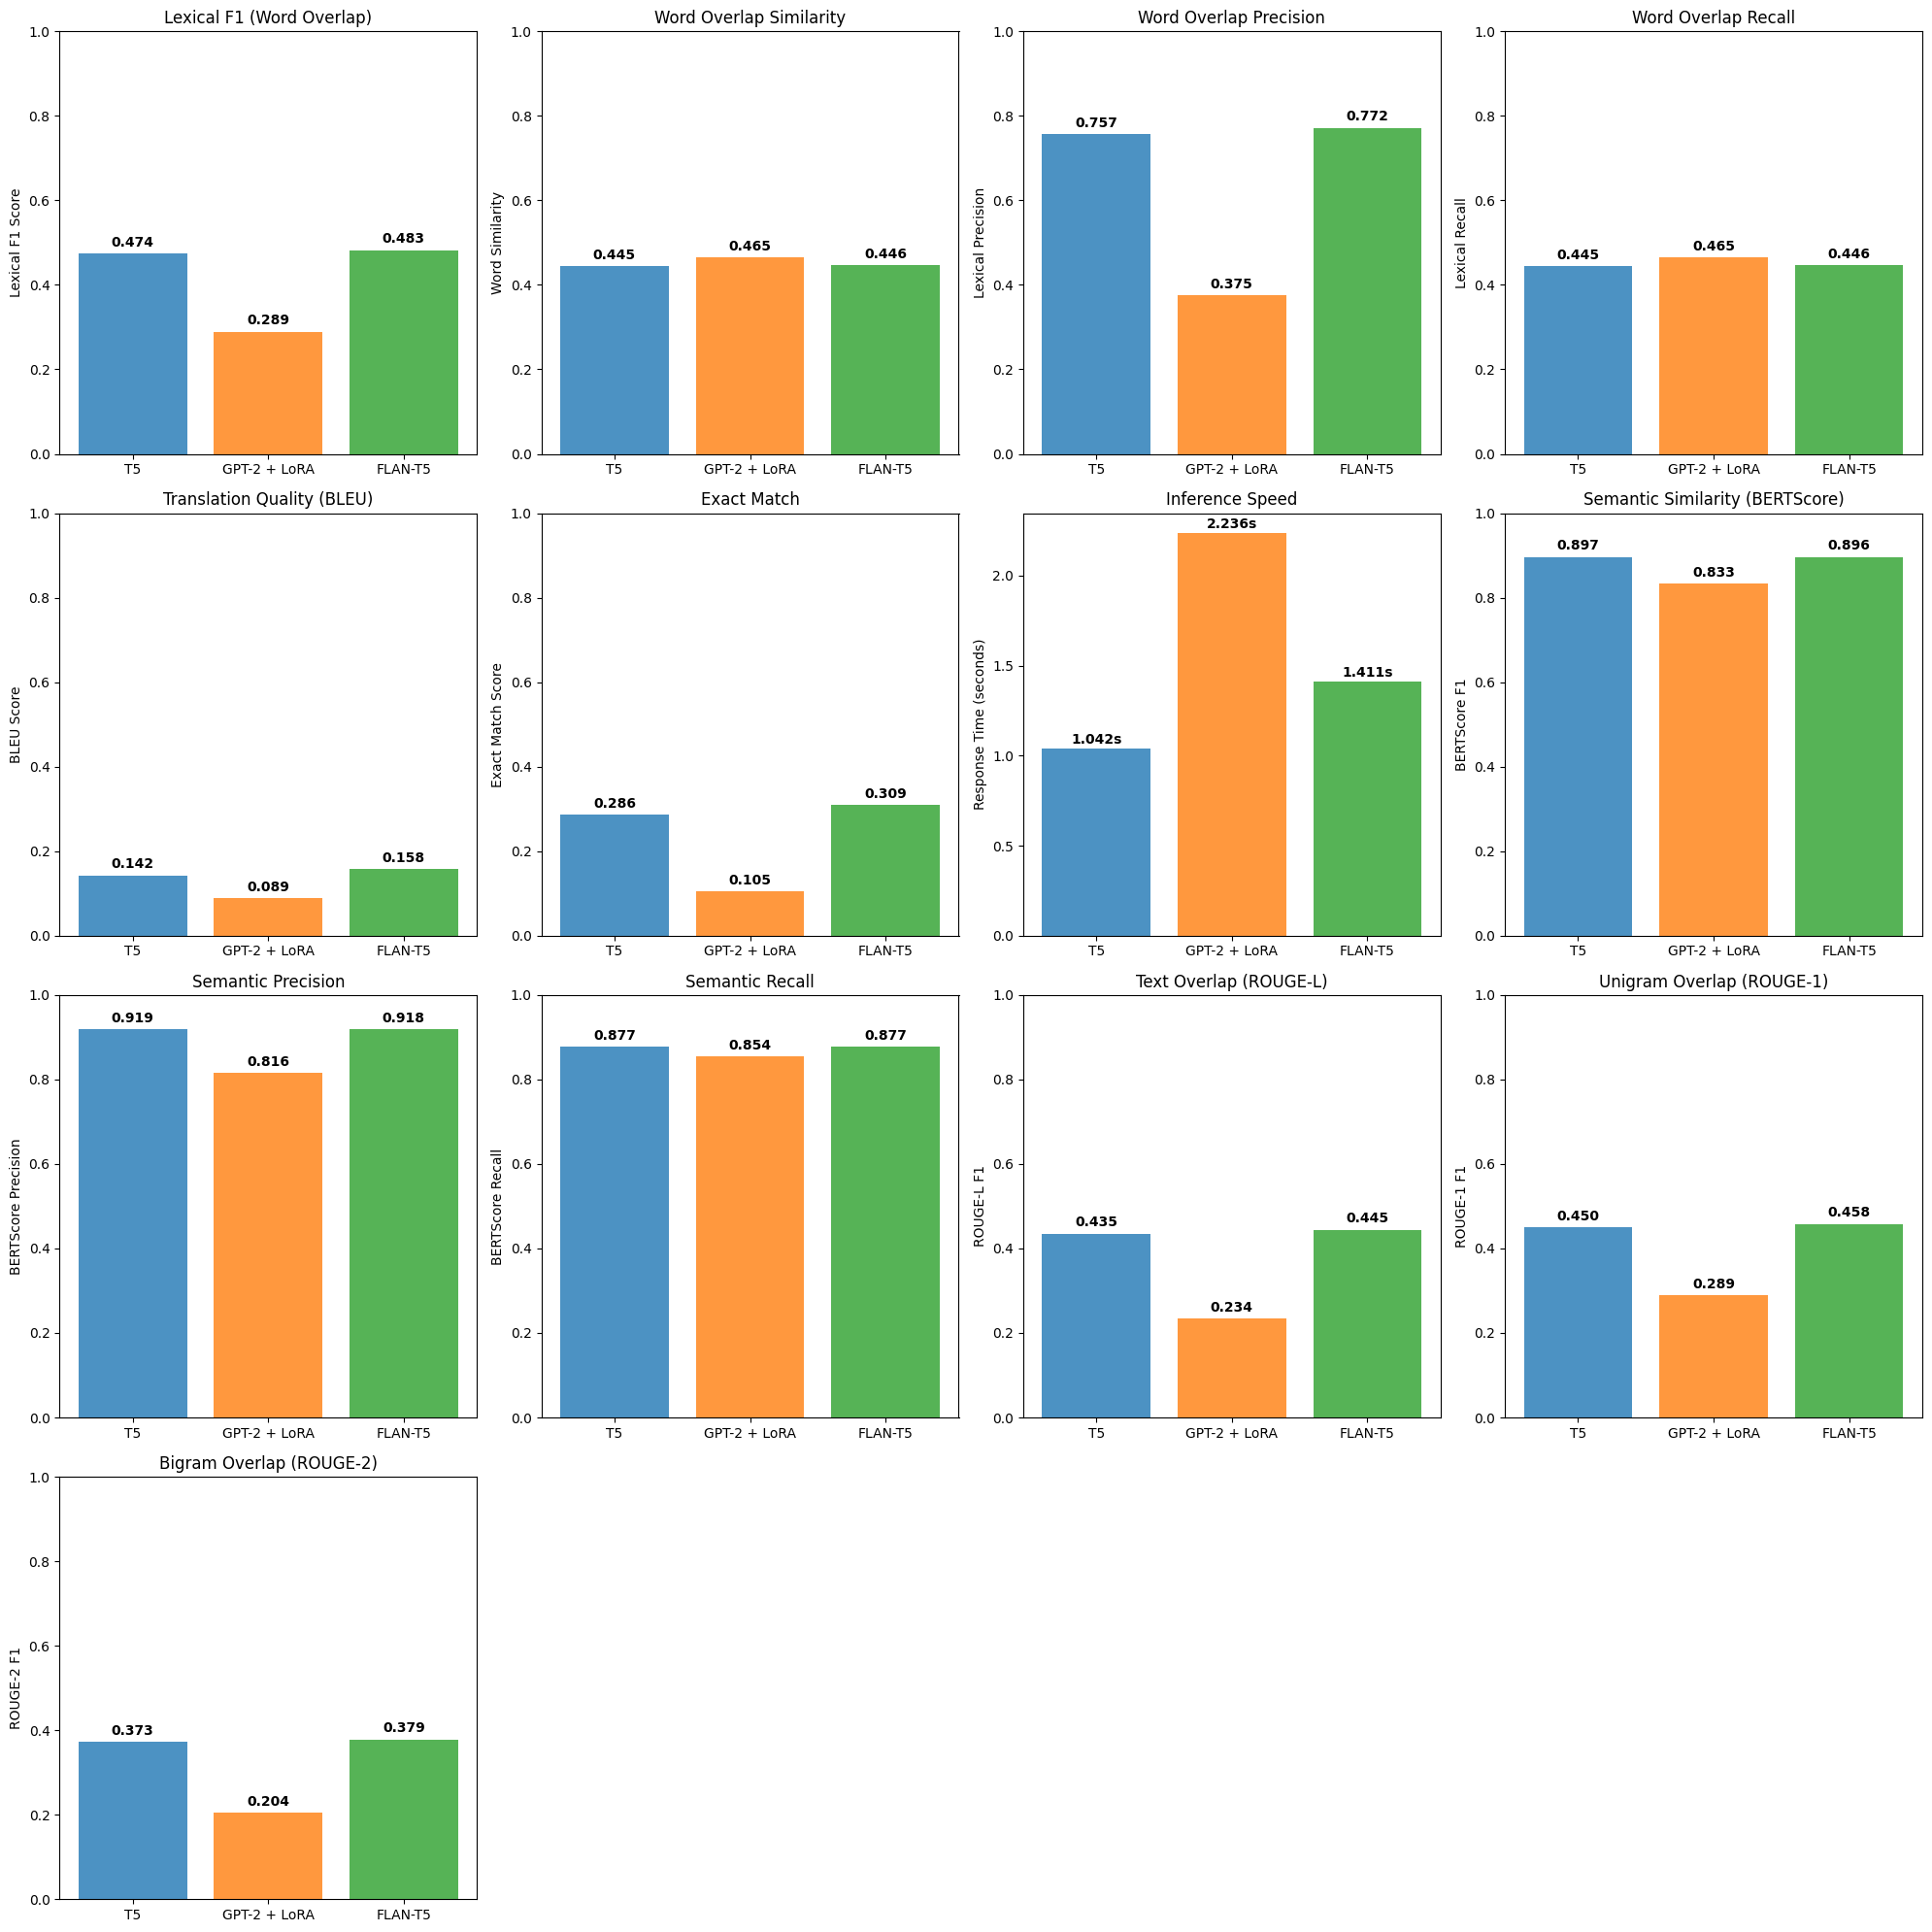

In [21]:
# Enhanced visualization with all metrics
def plot_comprehensive_results(t5_results, gpt2_results, flan_t5_results):
    models = ['T5', 'GPT-2 + LoRA', 'FLAN-T5']
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    
    # Define metrics to plot based on availability
    metrics_config = [
        ('avg_lexical_f1', 'Lexical F1 Score', 'Lexical F1 (Word Overlap)', 0, 1),
        ('avg_similarity', 'Word Similarity', 'Word Overlap Similarity', 0, 1),
        ('avg_lexical_precision', 'Lexical Precision', 'Word Overlap Precision', 0, 1),
        ('avg_lexical_recall', 'Lexical Recall', 'Word Overlap Recall', 0, 1),
        ('avg_bleu', 'BLEU Score', 'Translation Quality (BLEU)', 0, 1),
        ('avg_exact_match', 'Exact Match Score', 'Exact Match', 0, 1),
        ('avg_response_time', 'Response Time (seconds)', 'Inference Speed', None, None),
    ]
    
    # Add optional metrics if available
    if BERTSCORE_AVAILABLE:
        metrics_config.extend([
            ('avg_bertscore_f1', 'BERTScore F1', 'Semantic Similarity (BERTScore)', 0, 1),
            ('avg_bertscore_precision', 'BERTScore Precision', 'Semantic Precision', 0, 1),
            ('avg_bertscore_recall', 'BERTScore Recall', 'Semantic Recall', 0, 1),
        ])
    
    if ROUGE_AVAILABLE:
        metrics_config.extend([
            ('avg_rougeL_f1', 'ROUGE-L F1', 'Text Overlap (ROUGE-L)', 0, 1),
            ('avg_rouge1_f1', 'ROUGE-1 F1', 'Unigram Overlap (ROUGE-1)', 0, 1),
            ('avg_rouge2_f1', 'ROUGE-2 F1', 'Bigram Overlap (ROUGE-2)', 0, 1),
        ])
    
    # Calculate grid size
    n_metrics = len(metrics_config)
    n_cols = 4
    n_rows = (n_metrics + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = [axes] if n_cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for i, (metric, ylabel, title, ymin, ymax) in enumerate(metrics_config):
        if i >= len(axes):
            break
            
        scores = [t5_results[metric], gpt2_results[metric], flan_t5_results[metric]]
        bars = axes[i].bar(models, scores, color=colors, alpha=0.8)
        axes[i].set_ylabel(ylabel)
        axes[i].set_title(title)
        
        if ymin is not None and ymax is not None:
            axes[i].set_ylim(ymin, ymax)
            
        for bar, score in zip(bars, scores):
            if metric == 'avg_response_time':
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.3f}s',
                         ha='center', va='bottom', fontweight='bold')
            else:
                axes[i].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{score:.3f}',
                         ha='center', va='bottom', fontweight='bold')
    
    # Hide unused subplots
    for i in range(len(metrics_config), len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('comprehensive_model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Create comprehensive visualization
plot_comprehensive_results(t5_results, gpt2_results, flan_t5_results)

In [22]:
# Create summary table
def create_summary_table(t5_results, gpt2_results, flan_t5_results):
    metrics = [
        'Word Similarity', 'Lexical F1', 'Lexical Precision', 'Lexical Recall',
        'BLEU Score', 'Exact Match', 'Response Time (s)'
    ]
    
    t5_scores = [
        t5_results['avg_similarity'], t5_results['avg_lexical_f1'],
        t5_results['avg_lexical_precision'], t5_results['avg_lexical_recall'],
        t5_results['avg_bleu'], t5_results['avg_exact_match'],
        t5_results['avg_response_time']
    ]
    
    gpt2_scores = [
        gpt2_results['avg_similarity'], gpt2_results['avg_lexical_f1'],
        gpt2_results['avg_lexical_precision'], gpt2_results['avg_lexical_recall'],
        gpt2_results['avg_bleu'], gpt2_results['avg_exact_match'],
        gpt2_results['avg_response_time']
    ]
    
    flan_t5_scores = [
        flan_t5_results['avg_similarity'], flan_t5_results['avg_lexical_f1'],
        flan_t5_results['avg_lexical_precision'], flan_t5_results['avg_lexical_recall'],
        flan_t5_results['avg_bleu'], flan_t5_results['avg_exact_match'],
        flan_t5_results['avg_response_time']
    ]
    
    # Add optional metrics if available
    if BERTSCORE_AVAILABLE:
        metrics.extend(['BERTScore F1', 'BERTScore Precision', 'BERTScore Recall'])
        t5_scores.extend([t5_results['avg_bertscore_f1'], t5_results['avg_bertscore_precision'], t5_results['avg_bertscore_recall']])
        gpt2_scores.extend([gpt2_results['avg_bertscore_f1'], gpt2_results['avg_bertscore_precision'], gpt2_results['avg_bertscore_recall']])
        flan_t5_scores.extend([flan_t5_results['avg_bertscore_f1'], flan_t5_results['avg_bertscore_precision'], flan_t5_results['avg_bertscore_recall']])
    
    if ROUGE_AVAILABLE:
        metrics.extend(['ROUGE-1 F1', 'ROUGE-2 F1', 'ROUGE-L F1'])
        t5_scores.extend([t5_results['avg_rouge1_f1'], t5_results['avg_rouge2_f1'], t5_results['avg_rougeL_f1']])
        gpt2_scores.extend([gpt2_results['avg_rouge1_f1'], gpt2_results['avg_rouge2_f1'], gpt2_results['avg_rougeL_f1']])
        flan_t5_scores.extend([flan_t5_results['avg_rouge1_f1'], flan_t5_results['avg_rouge2_f1'], flan_t5_results['avg_rougeL_f1']])
    
    summary_df = pd.DataFrame({
        'Metric': metrics,
        'T5': [f'{score:.4f}' if i != 6 else f'{score:.4f}s' for i, score in enumerate(t5_scores)],
        'GPT-2 + LoRA': [f'{score:.4f}' if i != 6 else f'{score:.4f}s' for i, score in enumerate(gpt2_scores)],
        'FLAN-T5': [f'{score:.4f}' if i != 6 else f'{score:.4f}s' for i, score in enumerate(flan_t5_scores)]
    })
    
    return summary_df

# Display summary table
summary_table = create_summary_table(t5_results, gpt2_results, flan_t5_results)
print("\n" + "="*80)
print("SUMMARY TABLE")
print("="*80)
print(summary_table.to_string(index=False))



SUMMARY TABLE
             Metric      T5 GPT-2 + LoRA FLAN-T5
    Word Similarity  0.4449       0.4648  0.4464
         Lexical F1  0.4740       0.2892  0.4826
  Lexical Precision  0.7575       0.3754  0.7715
     Lexical Recall  0.4449       0.4648  0.4464
         BLEU Score  0.1424       0.0890  0.1575
        Exact Match  0.2863       0.1054  0.3086
  Response Time (s) 1.0425s      2.2357s 1.4108s
       BERTScore F1  0.8965       0.8335  0.8964
BERTScore Precision  0.9187       0.8160  0.9183
   BERTScore Recall  0.8774       0.8537  0.8775
         ROUGE-1 F1  0.4501       0.2892  0.4581
         ROUGE-2 F1  0.3725       0.2044  0.3785
         ROUGE-L F1  0.4351       0.2340  0.4446
